In [ ]:
import os
import cv2
import numpy as np
import dlib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
import random

# Load the Dlib facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Path to datasets
down_syndrome_path = 'downSyndrome'
healthy_path = 'healty'

# Define landmark pairs
pairs = [
    (36, 39),
    (39, 42),
    (42, 45),
    (27, 30),
    (30, 33),
    (33, 31),
    (33, 35),
    (30, 31),
    (30, 35),
    (33, 51),
    (51, 48),
    (51, 54),
    (51, 57),
    (48, 57),
    (54, 57),
    (39, 68), 
    (42, 68)  
]

# Check if the face is frontal by verifying symmetry
def is_frontal_face(landmarks):
    left_eye = np.mean(np.array(landmarks[36:42]), axis=0)
    right_eye = np.mean(np.array(landmarks[42:48]), axis=0)
    nose_tip = np.array(landmarks[30])

    # Calculate distances for symmetry
    eye_distance = np.linalg.norm(left_eye - right_eye)
    nose_to_left_eye = np.linalg.norm(nose_tip - left_eye)
    nose_to_right_eye = np.linalg.norm(nose_tip - right_eye)

    # Symmetry check threshold
    symmetry_threshold = 0.15 * eye_distance  # Loosened threshold for more flexibility
    return abs(nose_to_left_eye - nose_to_right_eye) < symmetry_threshold

# Modified get_landmarks function to accept either an image path or an image array
def get_landmarks(image_input):
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        
        # Add the extra landmark at the midpoint between 21 and 22
        midpoint_x = (points[21][0] + points[22][0]) // 2
        midpoint_y = (points[21][1] + points[22][1]) // 2
        points.append((midpoint_x, midpoint_y))
        
        # Check if the face is frontal
        if is_frontal_face(points):
            return points
    return None


# Data augmentation function
def augment_image(image):
    augmented_images = []
    
    # Flip horizontally
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # Rotation
    rows, cols = image.shape[:2]
    for angle in [-10, 10]:  # Rotate by -10 and +10 degrees
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(image, M, (cols, rows))
        augmented_images.append(rotated)
    
    return augmented_images

# Extract geometric features from specific landmark pairs
def extract_features(landmarks):
    features = []
    for i, j in pairs:
        x1, y1 = landmarks[i]
        x2, y2 = landmarks[j]
        distance = np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))
        features.append(distance)
    return np.array(features)

# Collect data and labels
X = []
y = []

for path, label in [(down_syndrome_path, 1), (healthy_path, 0)]:
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        landmarks = get_landmarks(img_path)
        if landmarks:
            features = extract_features(landmarks)
            X.append(features)
            y.append(label)
            
            # Apply data augmentation
            augmented_images = augment_image(img)
            for aug_img in augmented_images:
                aug_landmarks = get_landmarks(aug_img)
                if aug_landmarks:
                    aug_features = extract_features(aug_landmarks)
                    X.append(aug_features)
                    y.append(label)


X = np.array(X)
y = np.array(y)

# Handle NaNs and ensure consistent feature length
X = np.nan_to_num(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVM classifier
best_model = SVC(C=10, gamma='scale', kernel='rbf')
best_model.fit(X_train, y_train)

# Use the model to make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8421052631578947
Precision: 0.8378766140602583
Recall: 0.8248587570621468
AUC: 0.8411809548236333

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85       793
           1       0.84      0.82      0.83       708

    accuracy                           0.84      1501
   macro avg       0.84      0.84      0.84      1501
weighted avg       0.84      0.84      0.84      1501



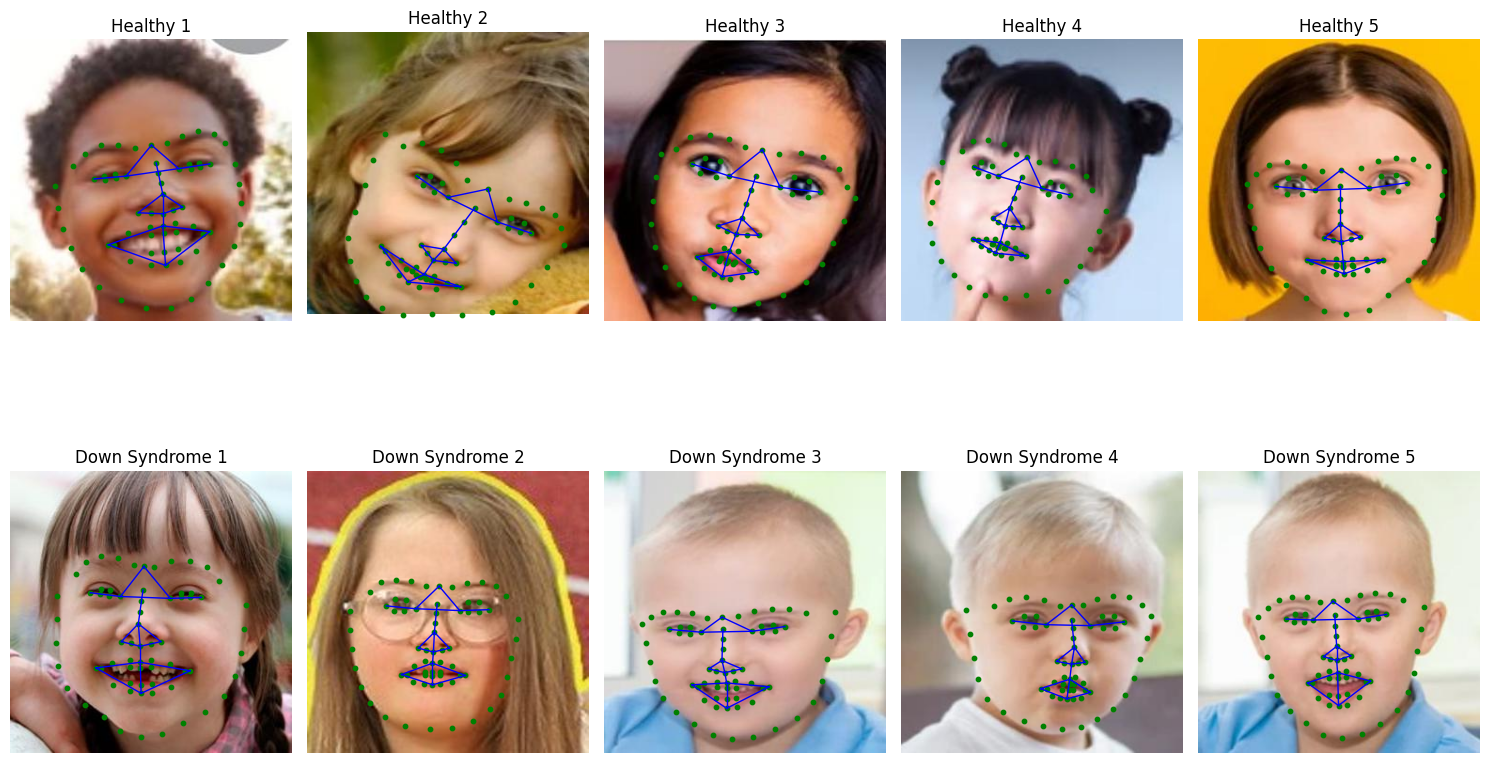

In [28]:
import matplotlib.pyplot as plt

# Function to plot landmarks on images
def plot_landmarks(image, landmarks, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for x, y in landmarks:
        plt.scatter(x, y, color='green', s=10)  # Red dots for landmarks
    for (i, j) in pairs:
        x1, y1 = landmarks[i]
        x2, y2 = landmarks[j]
        plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # Blue lines connecting pairs
    plt.title(title)
    plt.axis('off')

# Display 5 samples of each category
num_samples = 5
healthy_images = [img for img in os.listdir(healthy_path)]
down_syndrome_images = [img for img in os.listdir(down_syndrome_path)]

healthy_count = 0
down_syndrome_count = 0

plt.figure(figsize=(15, 10))

# Plot healthy samples with landmarks
for i, img_file in enumerate(healthy_images):
    if healthy_count >= num_samples:
        break
    img_path = os.path.join(healthy_path, img_file)
    img = cv2.imread(img_path)
    landmarks = get_landmarks(img_path)
    if landmarks and is_frontal_face(landmarks):
        plt.subplot(2, num_samples, healthy_count + 1)
        plot_landmarks(img, landmarks, f'Healthy {healthy_count + 1}')
        healthy_count += 1

# Plot Down syndrome samples with landmarks
for i, img_file in enumerate(down_syndrome_images):
    if down_syndrome_count >= num_samples:
        break
    img_path = os.path.join(down_syndrome_path, img_file)
    img = cv2.imread(img_path)
    landmarks = get_landmarks(img_path)
    if landmarks and is_frontal_face(landmarks):
        plt.subplot(2, num_samples, num_samples + down_syndrome_count + 1)
        plot_landmarks(img, landmarks, f'Down Syndrome {down_syndrome_count + 1}')
        down_syndrome_count += 1

plt.tight_layout()
plt.show()
